In [810]:
from matplotlib import pyplot as plt
import json
import numpy as np
import pandas as pd
from collections import OrderedDict

pcolors = OrderedDict([('blue', [0.00, 0.33, 0.66]),
                       ('green', [0.33, 0.66, 0.00]),
                       ('red', [0.66, 0.00, 0.00]),
                       ('cyan', [0.00, 0.66, 0.66]),
                       ('purple', [0.33, 0.00, 0.66]),
                       ('orange', [0.75, 0.50, 0.00])])

plt.rcParams['figure.figsize'] = (3.3, 2)
plt.rcParams['figure.dpi'] = 240
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['patch.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.edgecolor'] = 'w'
plt.rcParams['savefig.facecolor'] = 'w'
plt.rcParams['savefig.dpi'] = 600

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

rc = %config InlineBackend.rc
rc['savefig.dpi'] = 150

In [811]:
# setup 
instance_ids = ['4x4', '5x5', '7x8', '10x10']
hed = 10.
temperatures = [100, 30, 10, 3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
test_episodes = 10000

results_dir = '../results/rockwalk/'

In [812]:
# load instance info
instances = json.load(open('../resources/rockwalk/instances.json', 'r'))

In [813]:
# load trials
trial_path = '%s/rockwalk-smh-%s-d%.1f-t%.3f-test%d.json'

trials = {}
for i in instance_ids:
    trials[i] = {}
    for t in temperatures:
        try:
            trials[i][t] = json.load(open(trial_path % (results_dir,i,hed,t,test_episodes), 'r'))
            print('.', end='')
        except:
            pass        

............................................

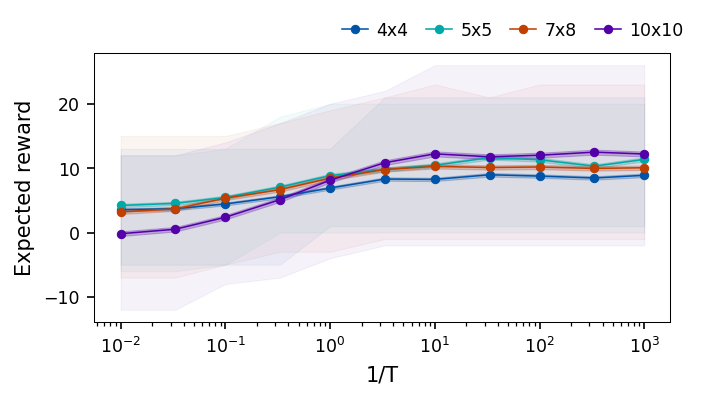

In [817]:
LWR = 0.16
UPR = 1 - LWR
# plot posterior intervals for rewards as a function of inverse temperature
rewards = pd.DataFrame(dict(((i,1/t), trials[i][t]['rewards']) 
                            for i in trials for t in trials[i]))

colors = {'4x4': [0.00, 0.33, 0.66],
          '5x5': [0.00, 0.66, 0.66],
          '7x8': [0.75, 0.25, 0.00],
          '10x10': [0.33, 0.00, 0.66]}

fig = plt.figure(figsize=(4.5, 2.5))
ax = fig.gca()
for i in instance_ids:
    mean_reward = rewards[i].mean()
    std_reward = rewards[i].std()/np.sqrt(test_episodes)
    lwr_reward = rewards[i].quantile(LWR)
    upr_reward = rewards[i].quantile(UPR)
    ax.fill_between(mean_reward.index, lwr_reward, upr_reward, alpha=0.05, color=colors[i])
    ax.fill_between(mean_reward.index, mean_reward - 3*std_reward, mean_reward + 3*std_reward,
                    alpha=0.25, color=colors[i])
    ax.semilogx(mean_reward.index,
        mean_reward.values,
        '-o', mec=colors[i],
        color = colors[i],
        label = i)


lgd = ax.legend(bbox_to_anchor=(0.15, 1.075, 0.9, .10), ncol=5, 
               handlelength=1.5, handletextpad=0.5, columnspacing=1.0)
ax.set_ylabel('Expected reward')
ax.set_xlabel('1/T')

fig.tight_layout(pad=0.05)
for ext in ['png','pdf','svg']:
    fig.savefig('../plots/rockwalk/rockwalk_reward_vs_steps.%s' % ext,
                bbox_extra_artists=(lgd,), bbox_inches='tight')

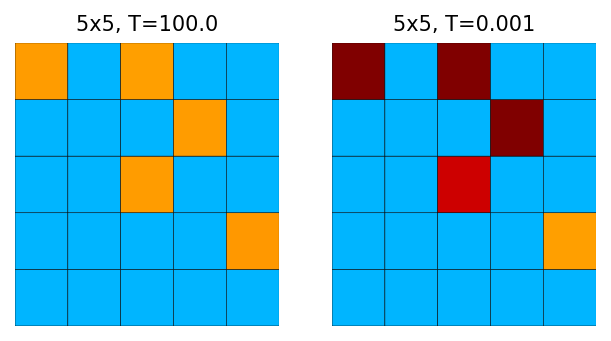

In [815]:
def plot_rock_counts(id, t, axis, **kwargs):
    grid = np.zeros((instances[id]['n'], instances[id]['n'])) 
    for ((x,y),count) in trials[id][t]['rock-counts']:
        grid[x,y] = 1.0 * count / len(trials[id][t]['rewards']) 
    axis.pcolor(grid.T, **kwargs)
    axis.set_title(f"{id}, T={t}")
    axis.axis('off')

for id in instance_ids:
    if len(trials[id].keys()):
        fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
        for i, t in enumerate([f(list(trials[id].keys())) for f in [np.max, np.min]]):
            plot_rock_counts(id, t,
                             axis=ax[i],
                             cmap=plt.cm.jet,
                             vmin=-0.35,
                             vmax=0.8,
                             edgecolors='k')

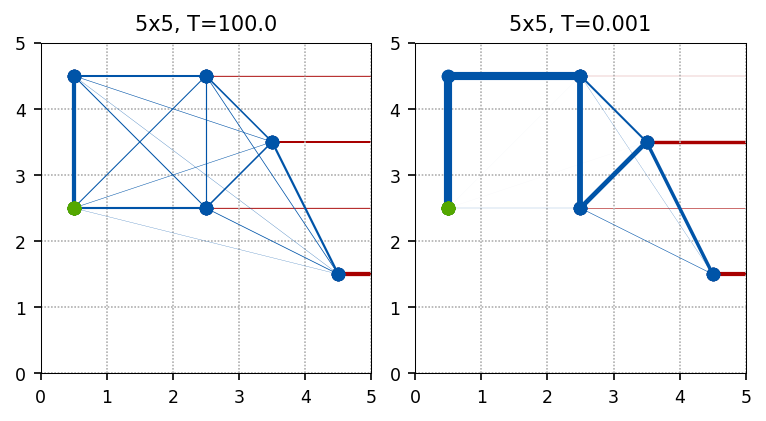

In [816]:
def plot_travel_counts(trial, instance, axis, **kwargs):
    linewidth = kwargs.get('linewidth', 4.0)
    for (((xa,ya), (xb,yb)), count) in trial['travel-counts']:
        kwargs['linewidth'] = linewidth * count / len(trial['rewards']) 
        try:
            kw = dict(kwargs)
            if xb == instance['n']:
                kw['color'] = pcolors['red']
                kw['zorder'] = -np.inf
            axis.plot([xa+0.5,xb+0.5], [ya+0.5,yb+0.5], 'o-', **kw)
            if (xa,ya) == (instance['x'],instance['y']):
                kw['color'] = pcolors['green']
                kw['zorder'] = np.inf
                axis.plot([xa+0.5,xa+0.5], [ya+0.5,ya+0.5], 'o-', **kw)
        except:
            print (xa,ya),(xb,yb)

for id in instance_ids:
    if len(trials[id].keys()):
        fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
        for i, t in enumerate([f(list(trials[id].keys())) for f in [np.max, np.min]]):
            plot_travel_counts(trials[id][t], 
                               instances[id],
                               axis=ax[i], 
                               color=pcolors['blue'], 
                               ms=6)
            ax[i].set_title(f"{id}, T={t}")
            ticks = range(0,instances[id]['n']+1)
            ax[i].set_xticks(ticks)
            ax[i].set_yticks(ticks)
            ax[i].set_xlim([0,instances[id]['n']])
            ax[i].set_ylim([0,instances[id]['n']])
            ax[i].set_aspect('equal')
            ax[i].grid(True, linestyle='--', dashes=(1,1))

        fig.tight_layout(pad=0.05)
        for ext in ['png','pdf','svg']:
            fig.savefig('../plots/rockwalk/rockwalk_flow_%s.%s' % (id,ext),dpi=600)        